In [65]:
# UZOP Projekt


## Implementation of Machine Learning Model to
## Predict Heart Failure Disease

## Dodavanje potrebnih biblioteka

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns

## Ucitavanje podataka

In [67]:
data = pd.read_csv("./heart_disease_uci.csv")
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Opis:

id: Identifikator za svaku osobu u skupu podataka
age: Dob osobe
sex: Spol osobe
dataset: Skup podataka ili izvor informacija (npr. Cleveland)
cp: Vrsta boli u prsima, kategorizirana kao "typical angina", "asymptomatic", "non-anginal" ili "atypical angina"
trestbps: Krvni tlak u mirovanju u mm Hg
chol: Razina kolesterola u serumu u mg/dl
fbs: Razina šećera u krvi bez konzumiranja hrane prije mjerenja, predstavljena kao TRUE ili FALSE
restecg: Rezultati elektrokardiografije u mirovanju, ukazuju na "lv hypertrophy" ili "normal"
thalch: Maximum heart rate achieved during the exercise test.
exang: Exercise-induced angina, represented as TRUE or FALSE.
oldpeak: ST depresija izazvana vježbanjem u odnosu na odmor
slope: Stanje ST pacijenta tijekom najvećeg opterećenja (npr., "downsloping", "flat", "upsloping").
ca: Broj velikih krvnih žila obojenih fluoroskopijom
thal: Rezultat testa kardiovaskularnog stresa, kategoriziran kao "fixed defect", "normal", or "reversible defect"
num: Prisutnost ili odsutnost bolesti srca, pri čemu "0" označava da nema bolesti srca, a "1" označava prisutnost bolesti srca

## Prikaz tipova podataka i deskriptivne statistike

In [68]:
data.shape

(920, 16)

In [69]:
data.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [70]:
data.nunique()

id          920
age          50
sex           2
dataset       4
cp            4
trestbps     61
chol        217
fbs           2
restecg       3
thalch      119
exang         2
oldpeak      53
slope         3
ca            4
thal          3
num           5
dtype: int64

Mičemo retke koji imaju num vrijednost različitu od 0 ili 1

In [71]:
data = data[(data['num'] == 0) | (data['num'] == 1)]
data.nunique()

id          676
age          49
sex           2
dataset       4
cp            4
trestbps     55
chol        200
fbs           2
restecg       3
thalch      107
exang         2
oldpeak      43
slope         3
ca            4
thal          3
num           2
dtype: int64

## Null vrijednosti

In [72]:
print(data.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     33
chol         26
fbs          54
restecg       2
thalch       33
exang        33
oldpeak      36
slope       260
ca          453
thal        383
num           0
dtype: int64


Ca, slope i thal stupci imaju null vrijednosti za skoro pola podataka tako da nema smisla ih koristiti će se ti stupci maknuti u potpunosti. Za restecg ćemo maknuti retke jer ih je samo dvoje. Ostale ćemo nadomjestiti pomoću KNN metode.

In [73]:
columns = ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'num']
data = data[columns]

data = data.dropna(subset=['restecg'])

## Micanje ne numerickih vrijednosti

In [74]:
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})

data['fbs'] = data['fbs'].astype(bool).astype(int)

data['exang'] = data['exang'].astype(bool).astype(int)

data = pd.get_dummies(data, columns=['cp', 'restecg'], drop_first=True)

data.drop('dataset', axis=1, inplace=True)

data.head()

,id,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,num,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality
0,1,63,1,145.0,233.0,1,150.0,0,2.3,0,0,0,1,0,0
2,3,67,1,120.0,229.0,0,129.0,1,2.6,1,0,0,0,0,0
3,4,37,1,130.0,250.0,0,187.0,0,3.5,0,0,1,0,1,0
4,5,41,0,130.0,204.0,0,172.0,0,1.4,0,1,0,0,0,0
5,6,56,1,120.0,236.0,0,178.0,0,0.8,0,1,0,0,1,0


Popunjavanje nedostajućih vrijednosti

In [75]:
knn_imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

In [76]:
data.head()

,id,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,num,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality
0,1.0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1.0,0.0,0.0,0.0,0.0,0.0
2,4.0,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0.0,1.0,0.0,1.0,0.0
3,5.0,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,0.0,1.0,0.0,0.0,1.0,0.0


In [77]:
print(data.isnull().sum())

id                          0
age                         0
sex                         0
trestbps                    0
chol                        0
fbs                         0
thalch                      0
exang                       0
oldpeak                     0
num                         0
cp_atypical angina          0
cp_non-anginal              0
cp_typical angina           0
restecg_normal              0
restecg_st-t abnormality    0
dtype: int64


## Provjera strsućih vrijednosti

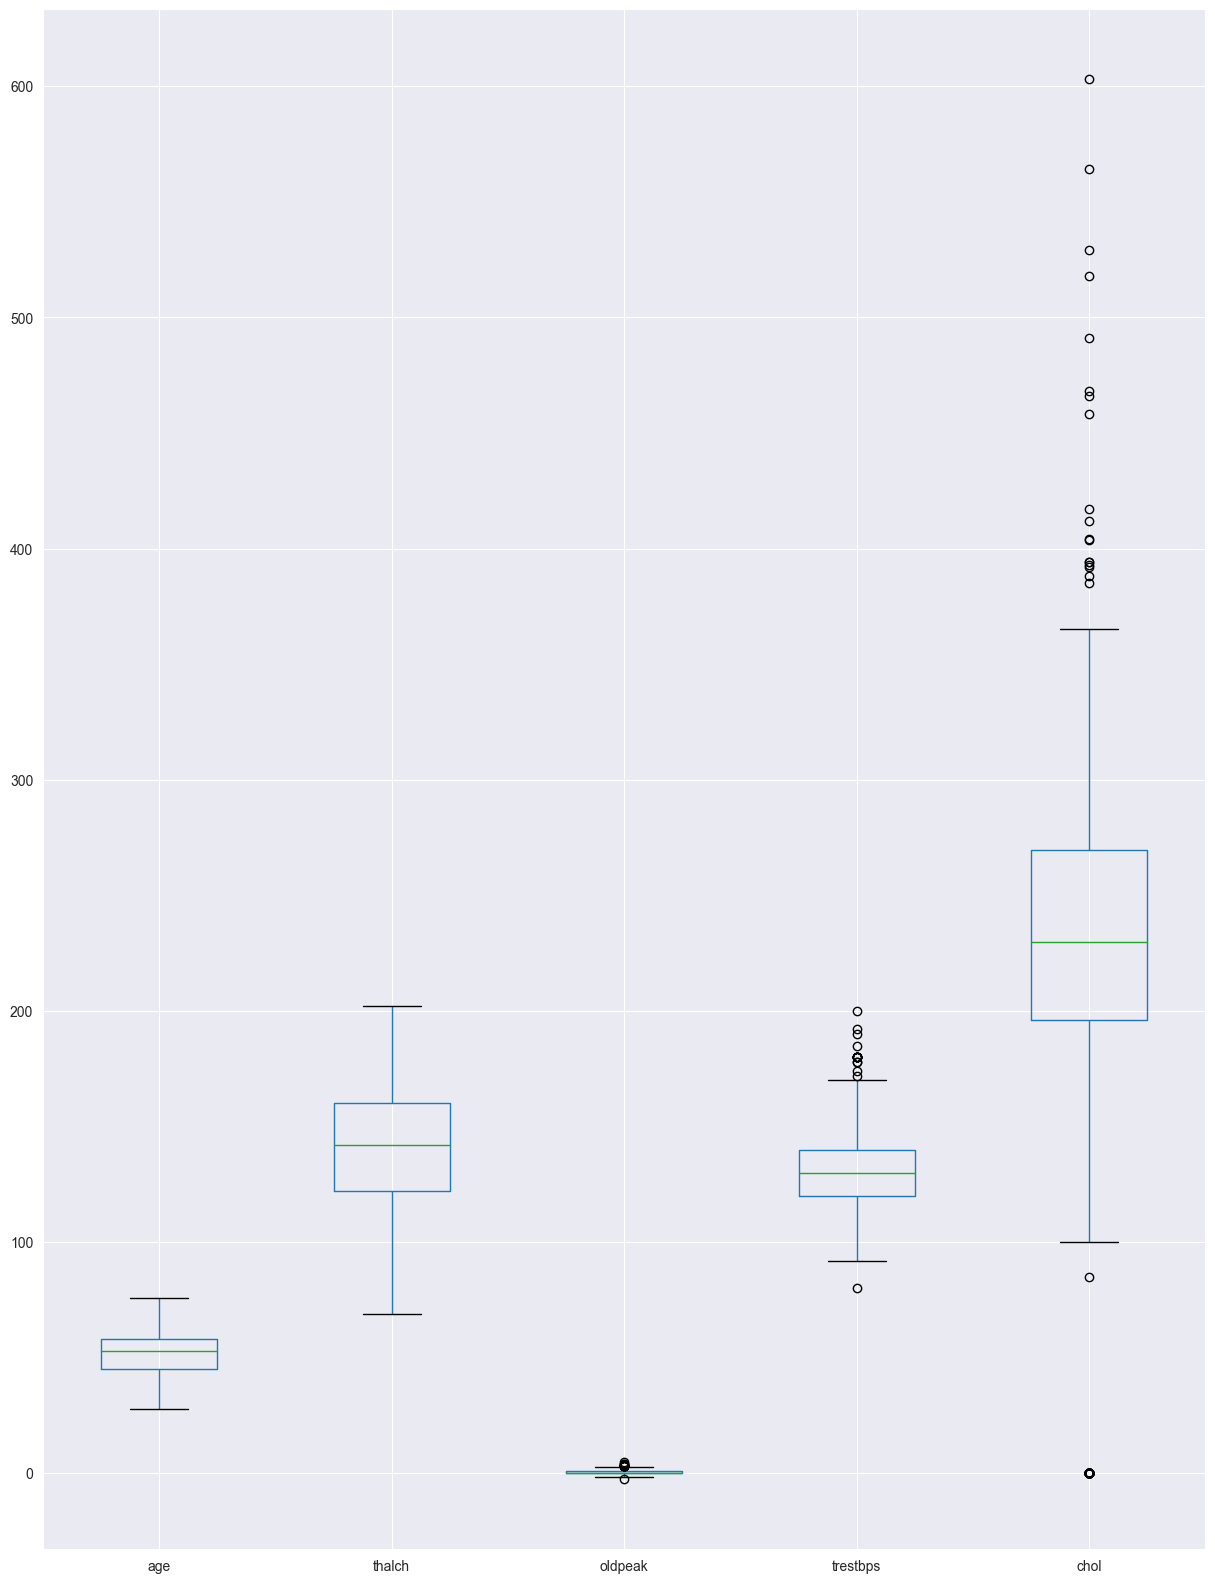

In [78]:
non_enum_cols = ['age', 'thalch', 'oldpeak', 'trestbps', 'chol']
data_non_enum = data[non_enum_cols]

plt.figure(figsize=(15, 20))
data_non_enum.boxplot()
plt.show()

Priblizeno oldpeak

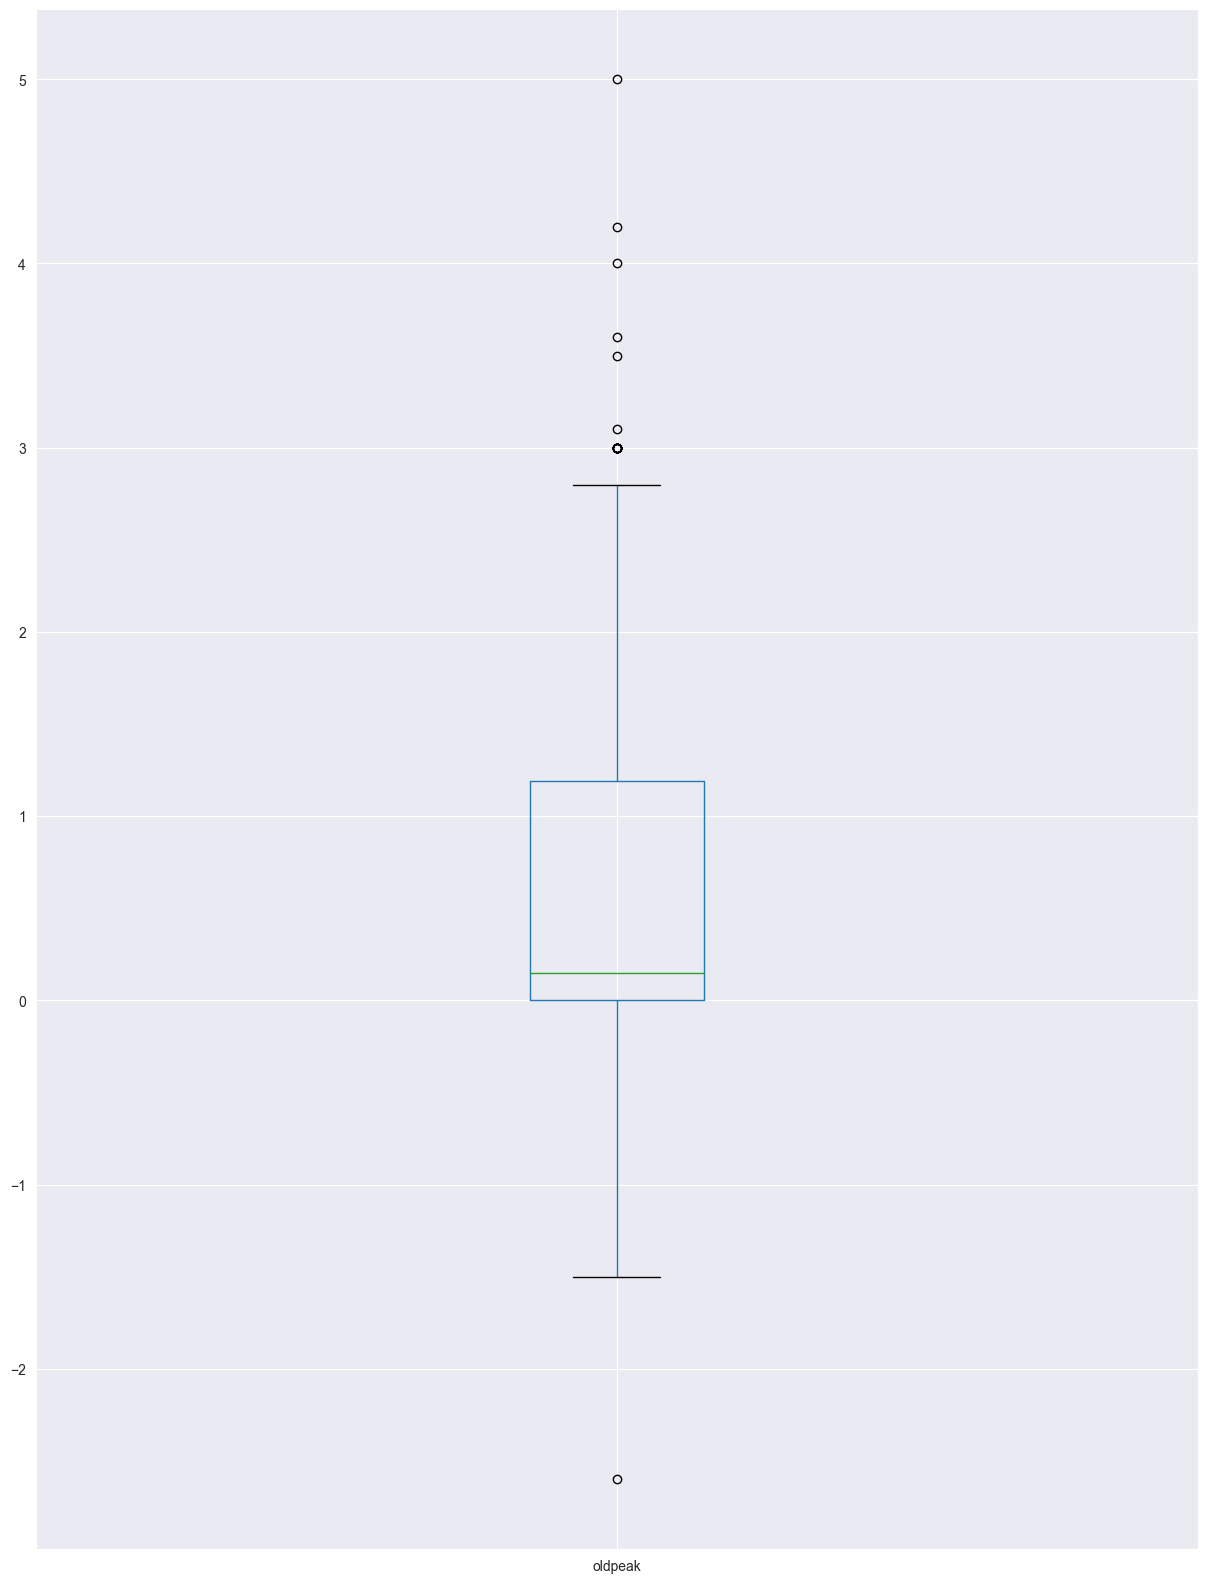

In [79]:
non_enum_cols = ['oldpeak']
data_non_enum = data[non_enum_cols]

plt.figure(figsize=(15, 20))
data_non_enum.boxplot()
plt.show()

Nećemo micati stršeće vrijednosti pošto su vrijednosti izmjerene na ljudima a možda su stvarno imali takve vrijednosti.

## Vizualizacija

Odnos vrijednosti

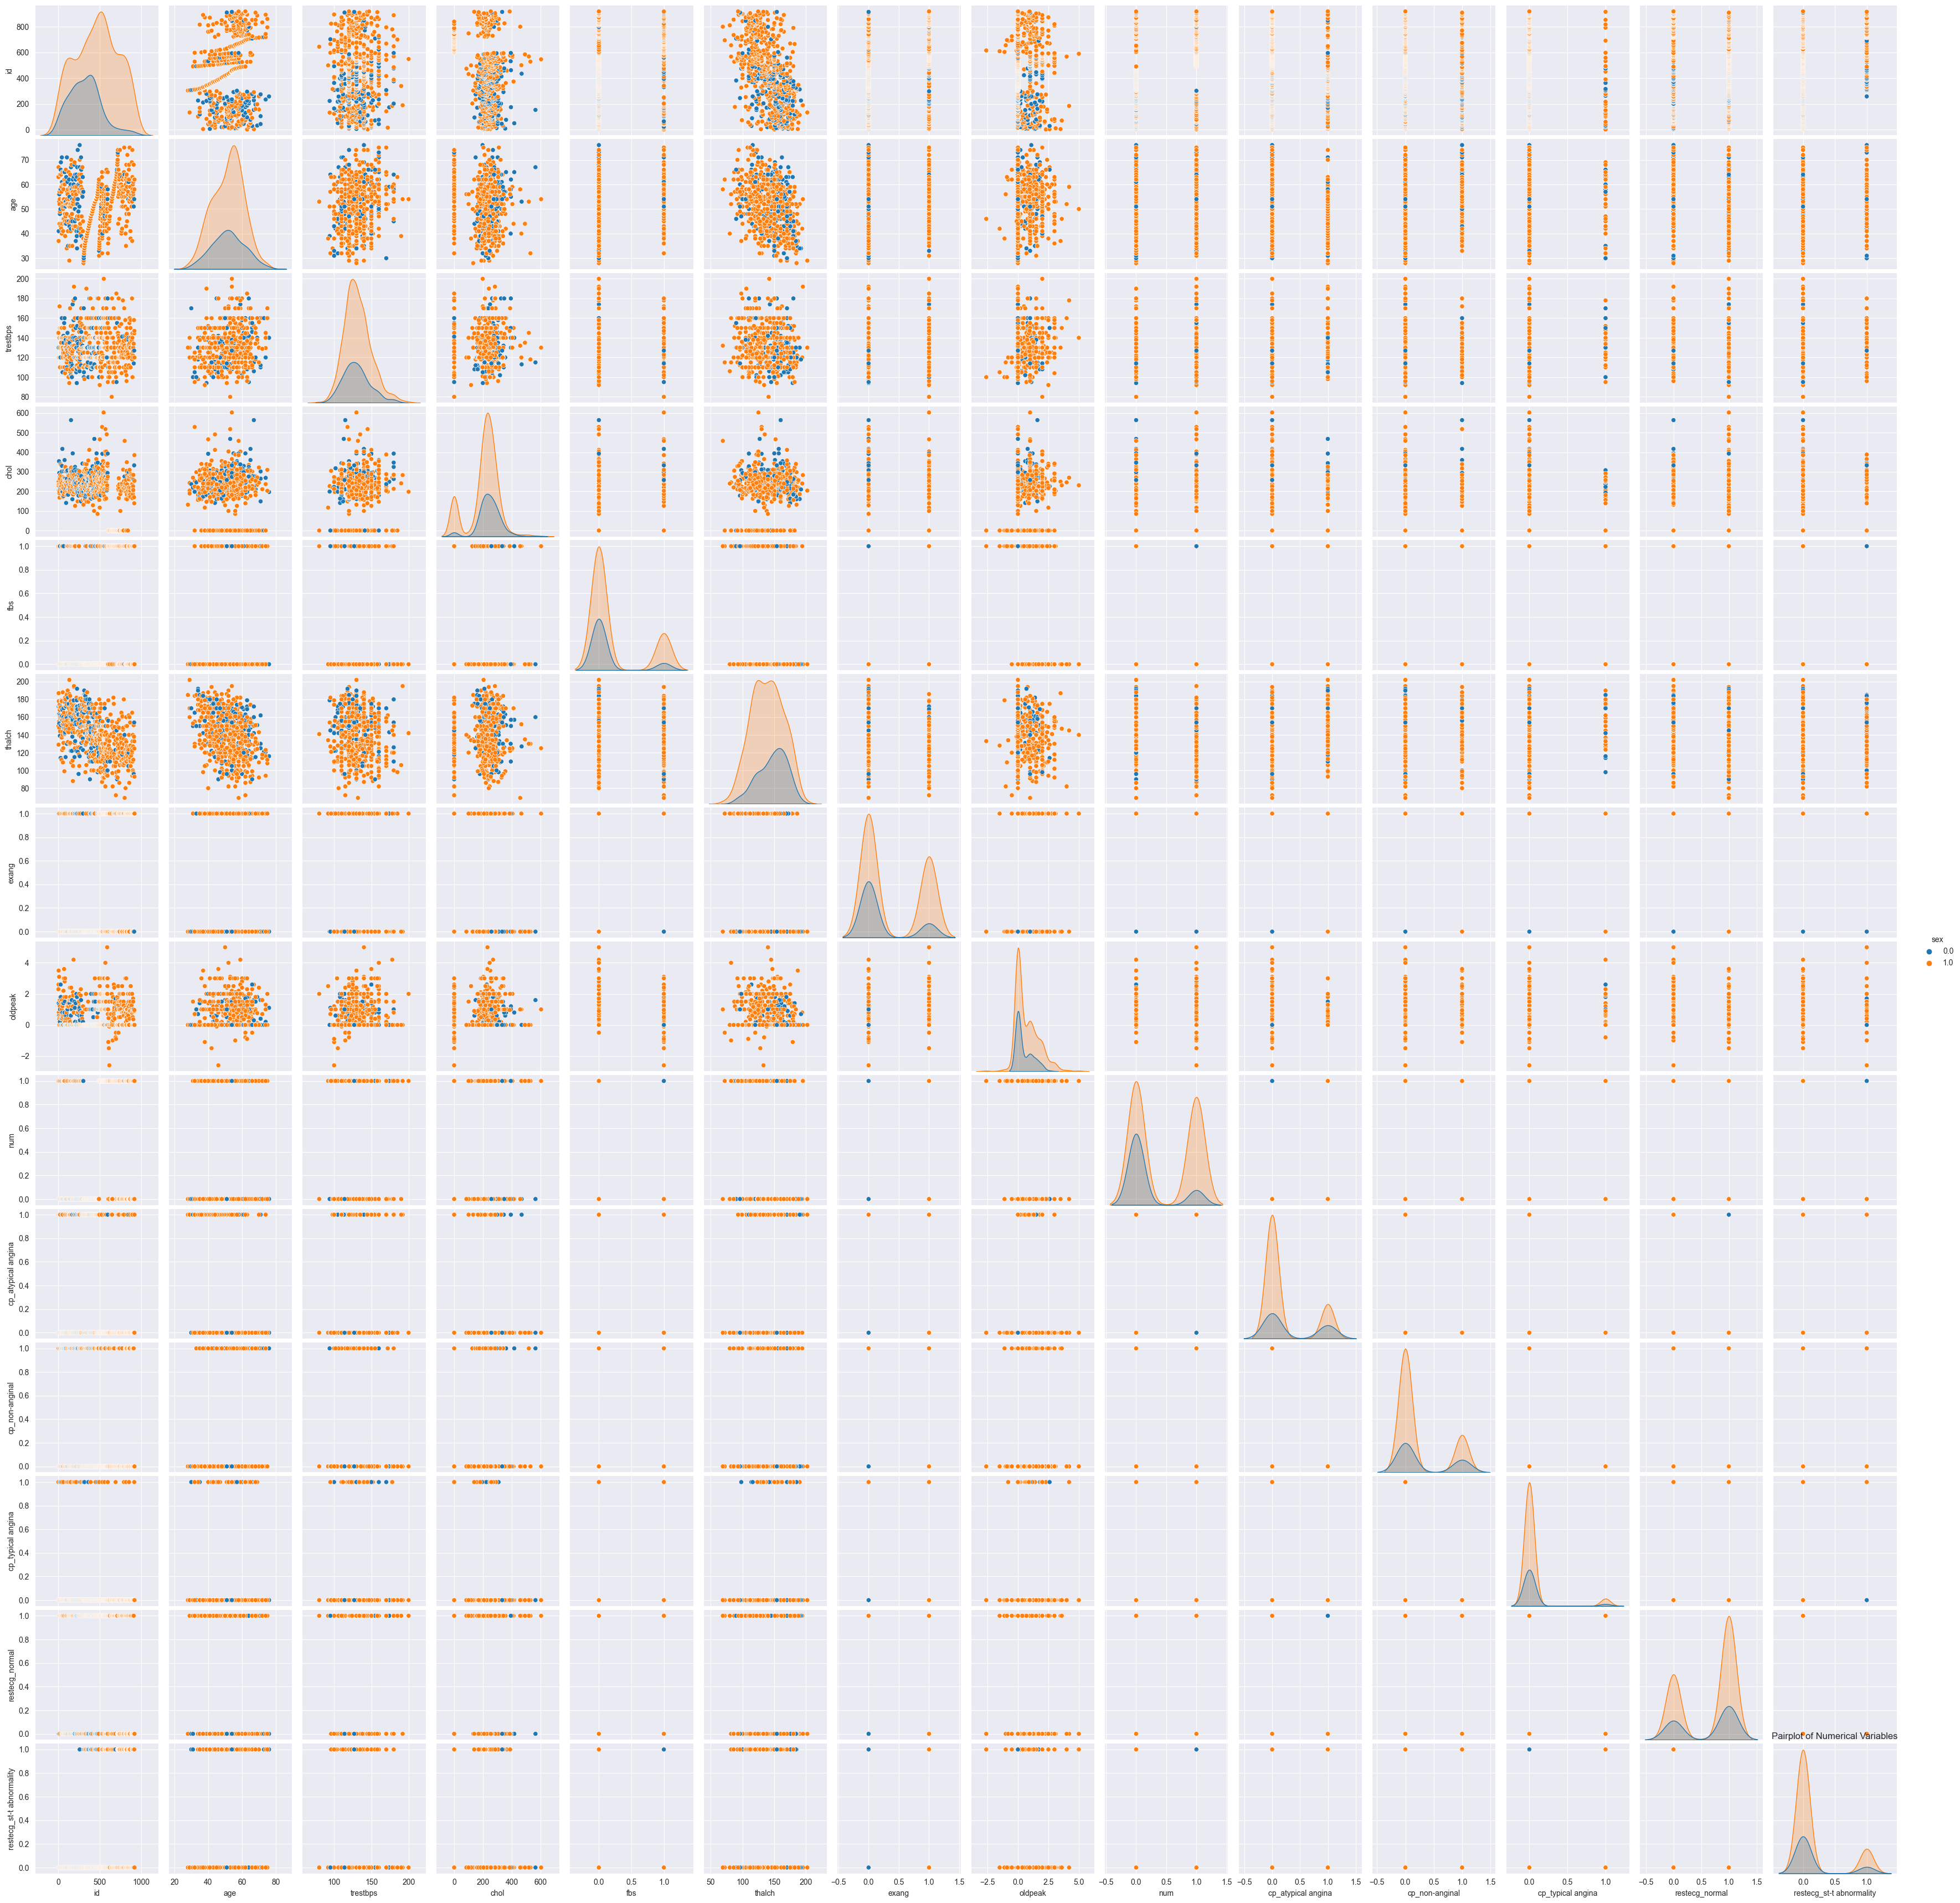

In [80]:
sns.pairplot(data, hue='sex', diag_kind='kde')
plt.title('Pairplot of Numerical Variables')
plt.show()

Korelacija

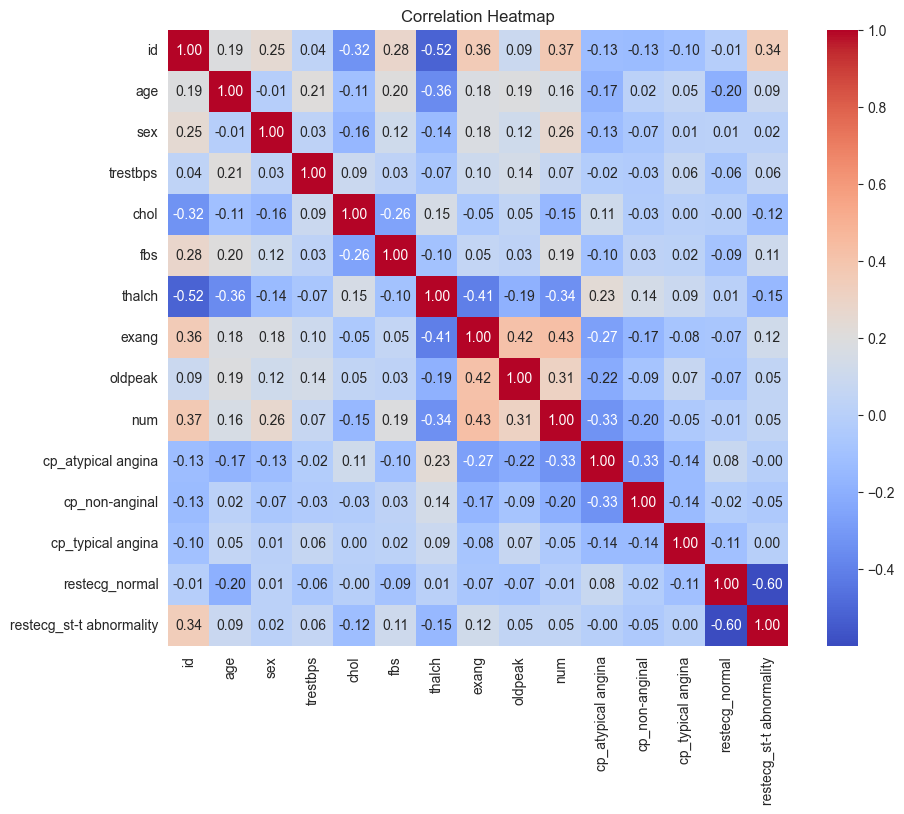

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Histogram koji prikazuje koliko ljudi kojih godina imaju srčanu bolest

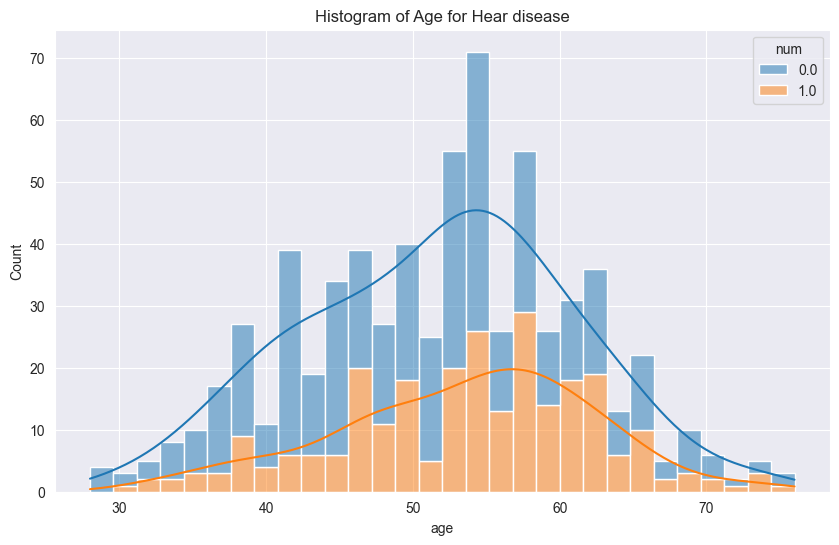

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='age', hue='num', multiple='stack', bins=30, kde=True)
plt.title('Histogram of Age for Hear disease')
plt.show()

Točkasti dijagram koji prikazuje kolesterol i otkucaje srca tijekom mirovanja u ovisnosti o srčanoj bolesti

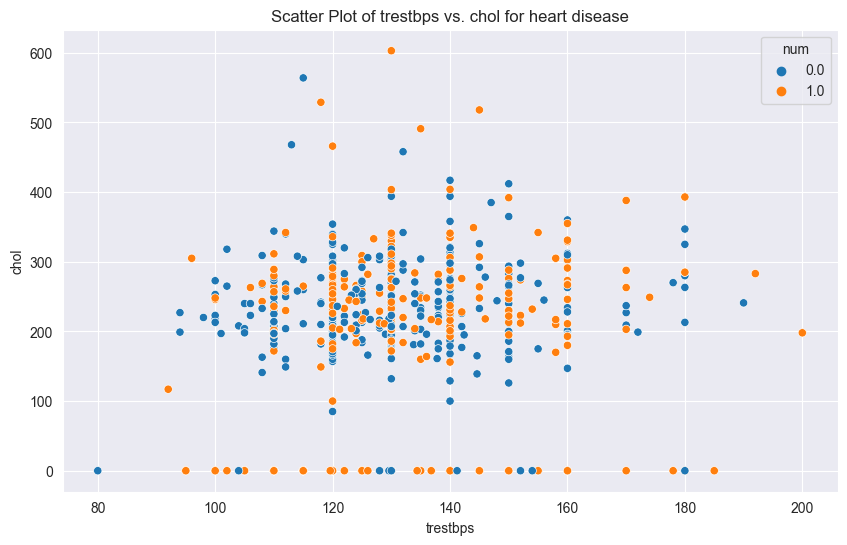

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='trestbps', y='chol', hue='num')
plt.title('Scatter Plot of trestbps vs. chol for heart disease')
plt.show()

## LAB2

Priprema podataka za modele

In [84]:
X = data.drop('num', axis=1)  # Features
y = data['num']  # Target variable

Import potrebnih biblioteka

In [85]:
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

Inicijalizacija modela

In [86]:
nb_model = GaussianNB()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
lr_model = LogisticRegression(max_iter=10000)
svm_model = SVC()

10-Fold Cross-Validation i evaluacija modela

In [96]:
models = [nb_model, dt_model, rf_model, lr_model, svm_model]

for model in models:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=skf)
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
    precision_per_class = precision_score(y, y_pred, average=None)
    recall_per_class = recall_score(y, y_pred, average=None)

    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy:.4f}")

    # Print precision for each class
    for class_label, precision in enumerate(precision_per_class):
        print(f'Precision for class {class_label}: {precision:.4f}')

    for class_label, recall in enumerate(recall_per_class):
        print(f'Recall for class {class_label}: {recall:.4f}')

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\n")

Model: GaussianNB
Accuracy: 0.7817
Precision for class 0: 0.8284
Precision for class 1: 0.7132
Recall for class 0: 0.8102
Recall for class 1: 0.7376
Confusion Matrix:
[[333  78]
 [ 69 194]]


Model: DecisionTreeClassifier
Accuracy: 0.7850
Precision for class 0: 0.8321
Precision for class 1: 0.7376
Recall for class 0: 0.8321
Recall for class 1: 0.7376
Confusion Matrix:
[[342  69]
 [ 69 194]]


Model: RandomForestClassifier
Accuracy: 0.8307
Precision for class 0: 0.8514
Precision for class 1: 0.8000
Recall for class 0: 0.8783
Recall for class 1: 0.7605
Confusion Matrix:
[[361  50]
 [ 63 200]]


Model: LogisticRegression
Accuracy: 0.7847
Precision for class 0: 0.8023
Precision for class 1: 0.7521
Recall for class 0: 0.8589
Recall for class 1: 0.6692
Confusion Matrix:
[[353  58]
 [ 87 176]]


Model: SVC
Accuracy: 0.8070
Precision for class 0: 0.8418
Precision for class 1: 0.7529
Recall for class 0: 0.8418
Recall for class 1: 0.7529
Confusion Matrix:
[[346  65]
 [ 65 198]]




### Zaključak

Kao i u istraživanju krištene su iste metode evaluacije i 10-Fold Cross validation, ali unatoč tome svaki model u istraživanju ima bolje vrijednosti evaluacije od ovih u zadatku. Podaci su pripremljeni na drugačiji način što je možda uzrokovalo razlike, ali razlika je oko 5-10% u prosjeku pa mislim da nije to najviše utjecalo. Moja pretpostavka je da je razlika nastala zbog platforme. U istraživanju je korišten RapidMiner-u koji ima podešene procese treniranja i evaluiranja automatski, a u projektu smo testirali sklearn modele.